In [1]:
EXPERIMENT_ID = 42
LOSS_ACT = 'sigmoid' #  'sigmoid', None, 'relu'
LOSS_TYPE = 'kl_ones' #  'kl', 'cr', 'l1', 'l2'
LOSS_REDUCTION = 'batchmean' #  'batchmean', mean','sum'
APPLY_LOG_SOFTMAX = True
MSE_PLUS_MINUS = '+'
APPLY_SPARSITY_TO = 'bottleneck' #all

epochs = 10  # args['epochs']
REG_PARAM = 0.0001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


Importing Modules

In [2]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
import pandas as pd
print("pandas: ", pd.__version__)
print("torch: ", torch.__version__)
print("numpy: ", np.__version__)

pandas:  1.1.0
torch:  1.6.0
numpy:  1.19.1


In [3]:
import socket
def get_var_by_comp_name(variableName):
    curCompName = socket.gethostname()
    retVal = None
    if variableName == 'khs_dir':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/home/wsubuntu/GitHub/keyhandshapediscovery'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'data_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/Datasets'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/DataPath'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
    if variableName == 'experiment_path':
        if curCompName == 'doga-MSISSD':
            base_dir = '/mnt/USB_HDD_1TB/GitHub/keyhandshapediscovery/experiments/SPARSE_TORCH'  # for bogazici kasa
        elif curCompName == 'WsUbuntu05' or curCompName == 'wsubuntu':
            base_dir = '/mnt/SSD_Data/vaesae_experiments'  # for WS Doga DHO
        elif curCompName == 'doga-msi-ubu':
            base_dir = None  # for laptop
        retVal = base_dir
        
    print(curCompName + '_' + variableName, '=',  retVal)
    if retVal is None:
        os.error(5)
    return retVal

In [4]:
khs_dir = get_var_by_comp_name('khs_dir')
data_path = get_var_by_comp_name('data_path')
experiment_path = get_var_by_comp_name('experiment_path')

sys.path.insert(1, khs_dir)
import helperFuncs as funcH

def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    uniq_pred_ids = np.unique(pred_vec)
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn, uniq_pred_ids

funcH.setPandasDisplayOpts()

# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

wsubuntu_khs_dir = /home/wsubuntu/GitHub/keyhandshapediscovery
wsubuntu_data_path = /mnt/SSD_Data/DataPath
wsubuntu_experiment_path = /mnt/SSD_Data/vaesae_experiments
cpu


Constructing the Argument Parsers

here I will change the data loader per my need

In [5]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": data_path,
    "experiment": os.path.join(experiment_path, 'sparse_torch_ae_' + str(EXPERIMENT_ID).zfill(3)),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(root=FOLDERS["data"], train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=FOLDERS["data"],train=False,download=True,transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [6]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type, enc_loss_act):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=32)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=32, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.enc_loss_act=enc_loss_act
        self.device = get_device()
        print("SparseAutoencoder - loss_type(" + loss_type +"), enc_loss_act(" + enc_loss_act +"), device(" + self.device + ")")

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        if self.enc_loss_act=='sigmoid':
            bottleneck = torch.sigmoid(self.enc5(x))
        elif self.enc_loss_act=='relu':
            bottleneck = F.relu(self.enc5(x))  
        elif self.enc_loss_act==None:
            bottleneck = self.enc5(x)
        else:
            os.error(4)
        
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE, enc_loss_act=LOSS_ACT).to(device)

SparseAutoencoder - loss_type(kl_ones), enc_loss_act(sigmoid), device(cpu)


In [7]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [9]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    rho_val = 1/bt.size(1)
    rho_mat = torch.tensor([rho_val] * np.ones(bt.size()), dtype=torch.float32).to(device)
    #https://discuss.pytorch.org/t/kl-divergence-produces-negative-values/16791/13
    #KLDLoss(p, q), sum(q) needs to equal one
    #p = log_softmax(tensor)
    loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def kl_divergence_ones(bt, reduction, apply_log_softmax):
    rho_mat = torch.zeros(bt.size(), dtype=torch.float32).to(device)
    _, preds = torch.max(bt, 1)
    rho_mat[range(bt.size(0)), preds] = 1
    if apply_log_softmax:
        loss_ret_1 = F.kl_div(F.log_softmax(bt, dim=1).to(device), rho_mat, reduction=reduction)
    else:
        loss_ret_1 = F.kl_div(bt, rho_mat, reduction=reduction)
    return loss_ret_1

def loss_crossentropy(bottleneck, reduction, apply_log_softmax, print_info):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    _, preds = torch.max(bottleneck, 1)
    if print_info:
        print("apply_log_softmax:",apply_log_softmax)
        print("bottleneck in :",bottleneck)

    if apply_log_softmax:
        loss_ret_1 = loss_fun(F.log_softmax(bottleneck, dim=1).to(device), preds)
    else:
        loss_ret_1 = loss_fun(bottleneck.to(device), preds)
    return loss_ret_1

In [10]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='kl_ones':
            loss += kl_divergence_ones(values, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX)
        if loss_type=='cre':
            loss += loss_crossentropy(values, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='kl_ones':
        loss += kl_divergence_ones(bottleneck, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, reduction=LOSS_REDUCTION, apply_log_softmax=APPLY_LOG_SOFTMAX, print_info=print_info)
        if print_info:
            print("bottleneck out:",bottleneck)
    if print_info:
        print(loss_type,loss)
    return loss

In [11]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - REG_PARAM * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + REG_PARAM * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn, uniq_pred_ids = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df, uniq_pred_ids

In [12]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn, uniq_pred_ids = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df, uniq_pred_ids

In [13]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_ACT : ", LOSS_ACT)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("APPLY_LOG_SOFTMAX : ", APPLY_LOG_SOFTMAX)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param(" + "{:.5f}".format(REG_PARAM) + ") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr, uniq_pred_ids_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va, uniq_pred_ids_va = validate(model, testloader, epoch, print_losses_fit)
    print("uniq_pred_ids_tr:", uniq_pred_ids_tr)
    print("uniq_pred_ids_va:", uniq_pred_ids_va)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time() 
print(f"{(end-start)/60:.3} minutes")
mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws :: 
EXPERIMENT_ID:  42
LOSS_TYPE :  kl_ones
LOSS_ACT :  sigmoid
LOSS_REDUCTION :  batchmean
APPLY_LOG_SOFTMAX :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(0.00010) * sp_loss
*****
 Epoch 0 of 10
TrEpoch(000) - kl_ones tensor(3.4199, grad_fn=<AddBackward0>)
sp_loss: 3.4199113845825195

       acc  bmx        bmn     mse       spr      run
0  15.478  1.0  5.233e-05  170.12  5940.042  170.714
ValEpoch(000) - 
      acc  bmx    bmn     run
0  14.42  1.0  0.038  18.793
uniq_pred_ids_tr: [ 4 13 15 16 17 20 21 25]
uniq_pred_ids_va: [13 17 21]
*****
 Epoch 1 of 10
TrEpoch(001) - 
       acc  bmx    bmn      mse       spr      run
0  11.432  1.0  0.019  106.158  5771.903  106.735
ValEpoch(001) - 
     acc  bmx   bmn     run
0  10.0  1.0  0.02  17.174
uniq_pred_ids_tr: [13 17 21]
uniq_pred_ids_va: [13]
*****
 Epoch 2 of 10
TrEpoch(002) - 
     acc  bmx   bmn     mse       spr     run
0  10.0  1.0  0.01  96.786  5773.311  97.364
ValEpoch(002) - 
     acc  bmx 

KeyboardInterrupt: 

In [14]:
print(result_df_tr_all)

      acc  bmx        bmn      mse       spr      run
0  15.478  1.0  5.233e-05  170.120  5940.042  170.714
1  11.432  1.0  1.885e-02  106.158  5771.903  106.735
2  10.000  1.0  1.036e-02   96.786  5773.311   97.364
3  10.000  1.0  1.234e-02   85.728  5768.952   86.305


In [15]:
print(result_df_va_all)

     acc  bmx    bmn     run
0  14.42  1.0  0.038  18.793
1  10.00  1.0  0.020  17.174
2  10.00  1.0  0.010  14.758
3  10.00  1.0  0.014  13.780


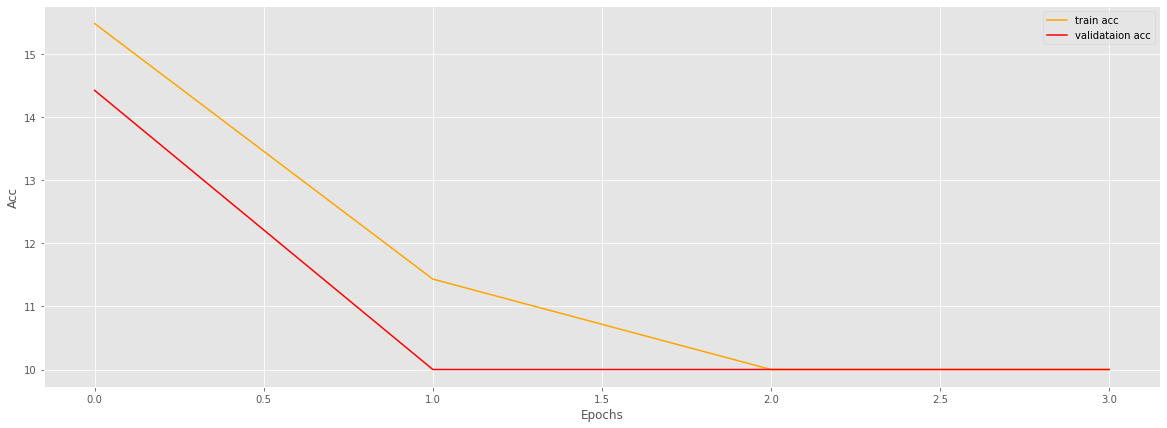

Max tr acc =  15.478333333333333
Max va acc =  14.42


In [16]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

all(5940.04), trmse(34.00), trspr(1.00), vaerr(316.00)


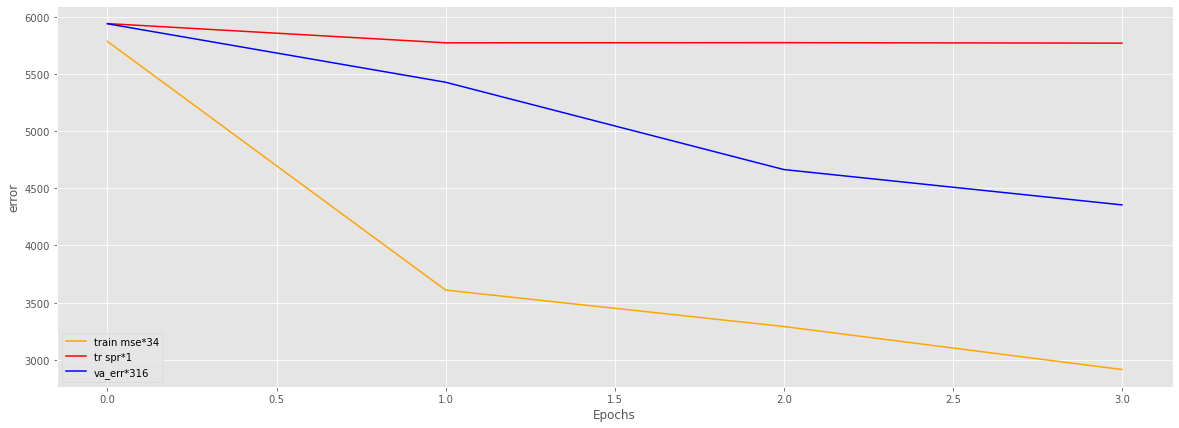

In [17]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr = result_df_tr_all.values[:,4].squeeze()
va_err = result_df_va_all.values[:,-1].squeeze()

mx_all = np.max([tr_mse, tr_spr, va_err])
tr_mse_mul = int(mx_all/np.max(tr_mse))
tr_spr_mul = int(mx_all/np.max(tr_spr))
va_err_mul = int(mx_all/np.max(va_err))
print("all({:.2f}), trmse({:.2f}), trspr({:.2f}), vaerr({:.2f})".format(mx_all, tr_mse_mul, tr_spr_mul, va_err_mul))

plt.figure(figsize=(20, 7))
plt.plot(tr_mse*tr_mse_mul, color='orange', label='train mse*'+str(tr_mse_mul))
plt.plot(tr_spr*tr_spr_mul, color='red', label='tr spr*'+str(tr_spr_mul))
plt.plot(va_err*va_err_mul, color='blue', label='va_err*'+str(va_err_mul))
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()